In [2]:
!pip install deap
import numpy as np
import scipy.stats as stats
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.6 MB/s eta 0:00:00


In [3]:
#prior initalizes the beta distribution before analysis (lambda) (constructor), and posterior stores the beta distribution
#after (adding the data we found)
class PoissonBetaModel:
    def __init__(self, data, alpha_prior=2, beta_prior=5):
        self.data = data
        self.alpha_prior = alpha_prior
        self.beta_prior = beta_prior

    def posterior(self):
        alpha_post = self.alpha_prior + np.sum(self.data)
        beta_post = self.beta_prior + len(self.data)
        return alpha_post, beta_post

In [4]:
#quantify randomness of genomic factor to then multiply it -- !!! HOW??
def simulate_genomic_factors():
    genomic_factor_dux4_fl = np.random.uniform(1, 10)
    genomic_factor_dux4_dbd = np.random.uniform(1, 10)
    return genomic_factor_dux4_fl, genomic_factor_dux4_dbd

In [5]:
#generate number of mRNA transcripts based on genomic factor (account for modulates the baseline expression rate to reflect how
#genomic variations (such as mutations, copy number variations, or epigenetic modifications) influence the expression
#level in a particular individual.)
def generate_expression_data(genomic_factor, base_expression_rate, num_copies, size=100):
    adjusted_expression_rate = genomic_factor * base_expression_rate * num_copies
    return np.random.poisson(adjusted_expression_rate, size)

In [6]:
genomic_factor_dux4_fl, genomic_factor_dux4_dbd = simulate_genomic_factors()
# !!! TBD
base_expression_rate_dux4_fl = 10
base_expression_rate_dux4_dbd = 2
# !!! TBD (depends on patient)
num_copies_dux4_fl = 1
num_copies_dux4_dbd = 5

In [7]:
#store mRNA transcripts
expression_data_dux4_fl = generate_expression_data(genomic_factor_dux4_fl, base_expression_rate_dux4_fl, num_copies_dux4_fl)
expression_data_dux4_dbd = generate_expression_data(genomic_factor_dux4_dbd, base_expression_rate_dux4_dbd, num_copies_dux4_dbd)

In [8]:
#apply poisson-beta model for both isoforms to find parameters !!! CHANGE ALPHA AND BETA
pois_beta_model_dux4_fl = PoissonBetaModel(expression_data_dux4_fl)
pois_beta_model_dux4_dbd = PoissonBetaModel(expression_data_dux4_dbd)
posterior_params_dux4_fl = pois_beta_model_dux4_fl.posterior()
posterior_params_dux4_dbd = pois_beta_model_dux4_dbd.posterior()

In [9]:
#calculate optimal number of DUX4-DBD copies to suppress DUX4-FL.
#we find the mean # after beta distribution and calculate the suppression ratio
def optimize_gene_copies(posterior_params_fl, posterior_params_dbd):
    alpha_fl_post, beta_fl_post = posterior_params_fl
    alpha_dbd_post, beta_dbd_post = posterior_params_dbd
    mean_fl = alpha_fl_post / (alpha_fl_post + beta_fl_post)
    mean_dbd = alpha_dbd_post / (alpha_dbd_post + beta_dbd_post)
    suppression_ratio = mean_fl / mean_dbd
    return suppression_ratio

In [10]:
optimal_copies_ratio = optimize_gene_copies(posterior_params_dux4_fl, posterior_params_dux4_dbd)
print("Initial optimal DUX4-DBD copies ratio:", optimal_copies_ratio)

Initial optimal DUX4-DBD copies ratio: 1.0076965304646632


In [11]:
#constants from paper
d0 = 0.246
vD = 0.00211
vT = 6.41
Dr = 1/20.2
TD = 1/13
infection_rate = 7.46e-4

In [12]:
experimental_data = {'S': 60, 'E': 20, 'I': 15, 'R': 5, 'D': 0}

In [13]:
#define the system of ODEs for the compartment model
def model(y, t, d0, vD, vT, Dr, TD, infection_rate):
    S, E, I, R, D = y
    dSdt = d0 * E - vD * S - infection_rate * (I + R) * S
    dEdt = vD * S - E * (d0 + TD * vT) - infection_rate * (I + R) * E
    dIdt = TD * vT * E + vD * R - d0 * I - Dr * I + infection_rate * (I + R) * E
    dRdt = d0 * I - vD * R - Dr * R + infection_rate * (I + R) * S
    dDdt = Dr * (R + I)
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

In [14]:
#initial conditions
y0 = [experimental_data['S'], experimental_data['E'], experimental_data['I'], experimental_data['R'], experimental_data['D']]
time_points = np.linspace(0, 48, 1000)

In [15]:
#function to run the simulation
def run_simulation(params, time_points):
    d0, vD, vT, Dr, TD, infection_rate = params
    solution = odeint(model, y0, time_points, args=(d0, vD, vT, Dr, TD, infection_rate))
    return solution

#define the fitness function for the genetic algorithm
def fitness(individual):
    infection_rate, n = individual
    params = [d0, vD, vT, Dr, TD, infection_rate]
    solution = run_simulation(params, time_points)
    S, E, I, R, D = solution[-1]
    model_data = {'S': S, 'E': E, 'I': I, 'R': R, 'D': D}
    fitness = 0
    for key in experimental_data:
        fitness -= abs(model_data[key] - experimental_data[key])
    return (fitness,)

In [16]:
#setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 0, 1)
toolbox.register("attr_int", np.random.randint, 1, 300)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_float, toolbox.attr_int), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", fitness)

population = toolbox.population(n=100)
ngen = 50
cxpb = 0.5
mutpb = 0.2

result, logbook = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, verbose=False)

best_individual = tools.selBest(population, k=1)[0]
best_infection_rate, best_n = best_individual
print("Best infection rate:", best_infection_rate)
print("Best n:", best_n)

final_params = [d0, vD, vT, Dr, TD, best_infection_rate]
final_solution = run_simulation(final_params, time_points)
S, E, I, R, D = final_solution.T

Best infection rate: 4.701686050162437e-05
Best n: 258.46722567328237


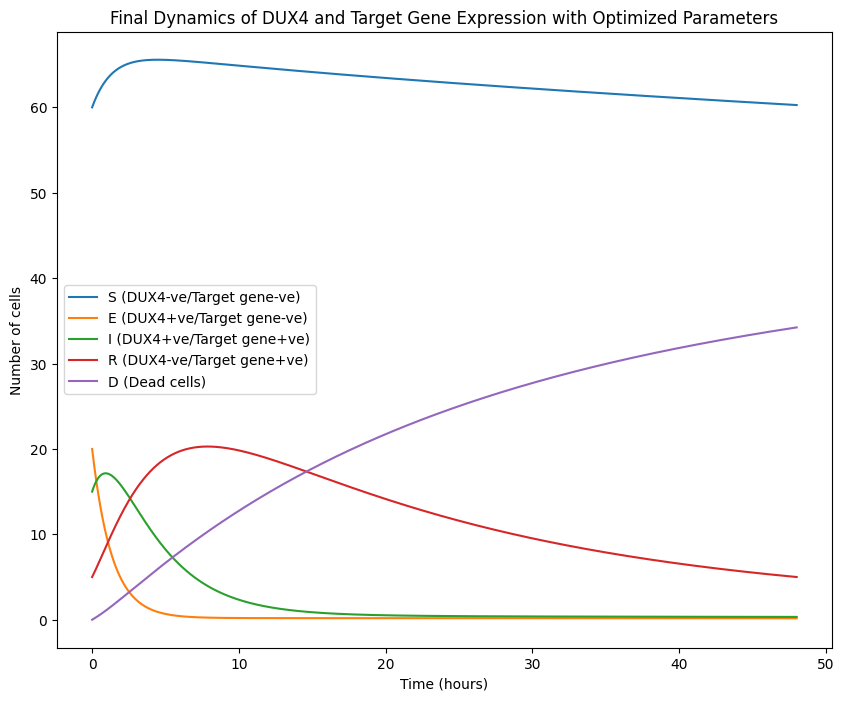

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(time_points, S, label='S (DUX4-ve/Target gene-ve)')
plt.plot(time_points, E, label='E (DUX4+ve/Target gene-ve)')
plt.plot(time_points, I, label='I (DUX4+ve/Target gene+ve)')
plt.plot(time_points, R, label='R (DUX4-ve/Target gene+ve)')
plt.plot(time_points, D, label='D (Dead cells)')
plt.xlabel('Time (hours)')
plt.ylabel('Number of cells')
plt.legend()
plt.title('Final Dynamics of DUX4 and Target Gene Expression with Optimized Parameters')
plt.show()